## Statistics on counts of OGs (columns) in Tara surface samples (rows)

* Finding significant OGs across groups of Tara samples using ANCOM
* Determining whether distribution of percent Tara samples found in differs for subgroups (z-test)

Does everything separately for pelag and proch data.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from skbio.stats.composition import ancom
from sys import argv
import matplotlib.pyplot as plt
%matplotlib inline

/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/luke/anaconda/envs/qiime190/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Assign variables

In [89]:
# species = argv[1]
# evalue = argv[2]
# clusters_path = argv[3]

In [74]:
# Prochlorococcus results
species = 'proch'
evalue = '1e-5'
myaxis = [0, 64, 0, 0.36]
clusters_path = '~/singlecell/clusters/orthomcl-pro4/groups.all_pro.list'

In [72]:
# Pelagibacter results
species = 'pelag'
evalue = '1e-5'
myaxis = [0, 64, 0, 0.36]
clusters_path = '~/singlecell/clusters/orthomcl-sar4/groups.all_sar.list'

### Format and save Tara metadata

In [92]:
# Tara metadata
df_tara_names = pd.read_csv('/Users/luke/singlecell/tara/Tara_Prok139_PANGAEA_Sample.csv')
df_tara_metadata =  pd.read_csv('/Users/luke/singlecell/tara/Tara_Table_W8.csv')
df_tara_metadata = df_tara_names.merge(df_tara_metadata)

# SRF metadata
df_tara_metadata.index = df_tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
index_SRF = [index for index in list(df_tara_metadata.index) if 'SRF' in index]
df_tara_metadata_SRF = df_tara_metadata.loc[index_SRF]
df_tara_metadata_SRF.index = df_tara_metadata_SRF.index

# Latitude column
df_tara_metadata_SRF['category_latitude'] = pd.Series(0, index=np.arange(len(df_tara_metadata_SRF.columns)), dtype='object')
for index, lat in abs(df_tara_metadata_SRF['Mean_Lat*']).iteritems():
    if lat < 23.5:
        df_tara_metadata_SRF.loc[index, 'category_latitude'] = 'tropical'
    elif lat > 40:
        df_tara_metadata_SRF.loc[index, 'category_latitude'] = 'temperate'
    else:
        df_tara_metadata_SRF.loc[index, 'category_latitude'] = 'subtropical'

# Temperature column
df_tara_metadata_SRF['category_temperature'] = pd.Series(0, index=np.arange(len(df_tara_metadata_SRF.columns)), dtype='object')
for index, temp in df_tara_metadata_SRF['Mean_Temperature [deg C]*'].iteritems():
    if temp < 10:
        df_tara_metadata_SRF.loc[index, 'category_temperature'] = 'polar'
    elif temp > 20:
        df_tara_metadata_SRF.loc[index, 'category_temperature'] = 'tropical'
    else:
        df_tara_metadata_SRF.loc[index, 'category_temperature'] = 'temperate'

# Red Sea column
df_tara_metadata_SRF['category_redsea'] = pd.Series(0, index=np.arange(len(df_tara_metadata_SRF.columns)), dtype='bool')
for index in df_tara_metadata_SRF.index:
    if index in ['TARA_031_SRF_0.22-1.6', 'TARA_031_SRF_<-0.22', 'TARA_032_SRF_0.22-1.6', 'TARA_032_SRF_<-0.22', 'TARA_033_SRF_0.22-1.6', 'TARA_034_SRF_0.1-0.22', 'TARA_034_SRF_0.22-1.6', 'TARA_034_SRF_<-0.22']:
        df_tara_metadata_SRF.loc[index, 'category_redsea'] = True
    else:
        df_tara_metadata_SRF.loc[index, 'category_redsea'] = False

In [93]:
# export mapping file
df_tara_metadata_SRF.to_csv('tara_metadata_SRF.tsv', sep='\t')

### Format and save count data

In [75]:
# Paths of input files, containing cluster counts in Tara samples
paths = pd.Series.from_csv('/Users/luke/singlecell/tara/paths_%s_%s.list' % (species, evalue), header=-1, sep='\t', index_col=None)

# Data frame of non-zero cluster counts in Tara samples (NaN if missing in sample but found in others)
pieces = []
for path in paths:
    fullpath = "/Users/luke/singlecell/tara/PROK-139/%s" % path
    counts = pd.DataFrame.from_csv(fullpath, header=-1, sep='\t', index_col=0)
    pieces.append(counts)
df_nonzero = pd.concat(pieces, axis=1)
headings = paths.tolist()
df_nonzero.columns = headings

# SRF dataframe, transposed, zeros, plus 1, renamed indexes
col_SRF = [col for col in list(df_nonzero.columns) if 'SRF' in col]
df_nonzero_SRF = df_nonzero[col_SRF]
df_nonzero_SRF_T = df_nonzero_SRF.transpose()
df_nonzero_SRF_T.fillna(0, inplace=True)
df_nonzero_SRF_T_plusOne = df_nonzero_SRF_T + 1
df_nonzero_SRF_T_plusOne.index = [re.sub(species, 'TARA', x) for x in df_nonzero_SRF_T_plusOne.index]
df_nonzero_SRF_T_plusOne.index = [re.sub('_1e-5', '', x) for x in df_nonzero_SRF_T_plusOne.index]

# Dataframe of all clusters (includes clusters missing from Tara)
clusters = pd.Series.from_csv(clusters_path, header=-1, sep='\t', index_col=None)
df_all = df_nonzero.loc[clusters]
df_all_SRF = df_all[col_SRF]
df_all_SRF_T = df_all_SRF.transpose()
df_all_SRF_T.fillna(0, inplace=True)

# remove '1e-5' from count indexes
df_nonzero_SRF_T.index = [re.sub('_1e-5', '', x) for x in df_nonzero_SRF_T.index]
df_all_SRF_T.index = [re.sub('_1e-5', '', x) for x in df_all_SRF_T.index]

In [95]:
# export counts to file
df_nonzero_SRF_T.to_csv('tara_%s_nonzero_SRF.csv' % species)
df_all_SRF_T.to_csv('tara_%s_all_SRF.csv' % species)

### ANCOM

In [96]:
# ANCOM with defaults alpha=0.05, tau=0.02, theta=0.1
# for grouping in ['category_latitude', 'category_temperature', 'category_redsea']:
#     results = ancom(df_nonzero_SRF_T_plusOne, df_tara_metadata_SRF[grouping], multiple_comparisons_correction='holm-bonferroni')
#     results.to_csv('ancom.%s_nonzero_SRF_T_plusOne.%s.csv' % (species, grouping))

### Z-test

In [76]:
# lookup dict for genus name
dg = {
    'pelag': 'Pelagibacter',
    'proch': 'Prochlorococcus'
}

In [77]:
# load OG metadata to determine RS-only OGs
df_og_metadata = pd.read_csv('/Users/luke/singlecell/notebooks/og_metadata.tsv', sep='\t', index_col=0)

In [78]:
og_rs = df_og_metadata.index[(df_og_metadata['Red_Sea_only'] == True) & (df_og_metadata['genus'] == dg[species])]
og_other = df_og_metadata.index[(df_og_metadata['Red_Sea_only'] == False) & (df_og_metadata['genus'] == dg[species])]

In [79]:
df_all_SRF_T_rs = df_all_SRF_T[og_rs]
df_all_SRF_T_other = df_all_SRF_T[og_other]

In [80]:
count = (df_all_SRF_T > 0).sum()
count_rs = (df_all_SRF_T_rs > 0).sum()
count_other = (df_all_SRF_T_other > 0).sum()

In [17]:
# save count data
count.to_csv('hist_counts_%s_ALL_og_presence_absence_in_63_tara_srf.csv' % species)
count_rs.to_csv('hist_counts_%s_RSassoc_og_presence_absence_in_63_tara_srf.csv' % species)

In [81]:
num_samples = df_all_SRF_T.shape[0]
num_ogs = max_bin = df_all_SRF_T.shape[1]
num_ogs_rsonly = count_rs.shape[0]
num_ogs_other = count_other.shape[0]

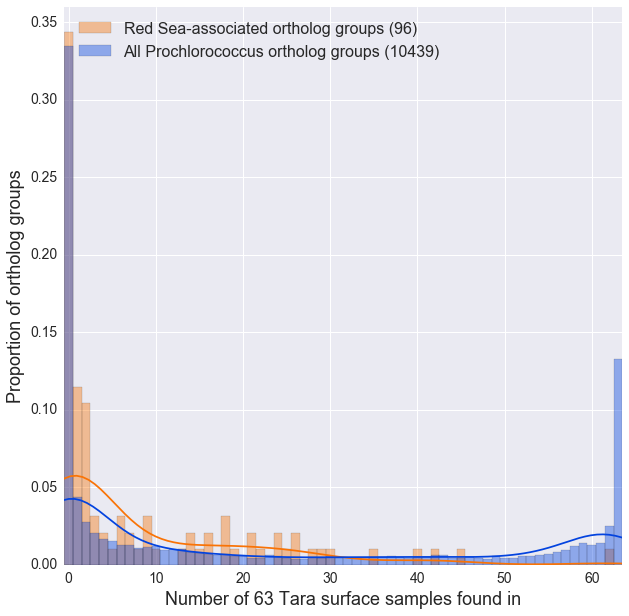

In [82]:
# all OGs AND RS-assoc OGs
plt.figure(figsize=(10,10))
sns.distplot(count_rs, bins=np.arange(num_samples+2), color=sns.xkcd_rgb['orange'], label='Red Sea-associated ortholog groups (%s)' % num_ogs_rsonly)
sns.distplot(count, bins=np.arange(num_samples+2), color=sns.xkcd_rgb['blue'], label='All %s ortholog groups (%s)' % (dg[species], num_ogs))
plt.xlabel('Number of %s Tara surface samples found in' % num_samples, fontsize=18)
plt.ylabel('Proportion of ortholog groups', fontsize=18)
plt.xticks(np.arange(0,num_samples+1,10)+0.5, ('0', '10', '20', '30', '40', '50', '60'), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.axis(myaxis)
plt.savefig('hist_%s_paper_og_presence_absence_in_63_tara_srf.pdf' % species)

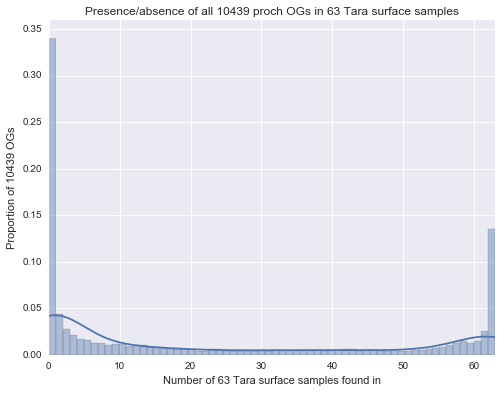

In [116]:
# all OGs
plt.figure(figsize=(8,6))
sns.distplot(count, bins=num_samples+1)
plt.axis([-0, num_samples, 0, .35])
plt.xlabel('Number of %s Tara surface samples found in' % num_samples)
plt.ylabel('Proportion of %s OGs' % num_ogs)
plt.title('Presence/absence of all %s %s OGs in %s Tara surface samples' % (num_ogs, species, num_samples))
plt.axis(myaxis)
plt.savefig('hist_%s_all_og_presence_absence_in_63_tara_srf.pdf' % species)

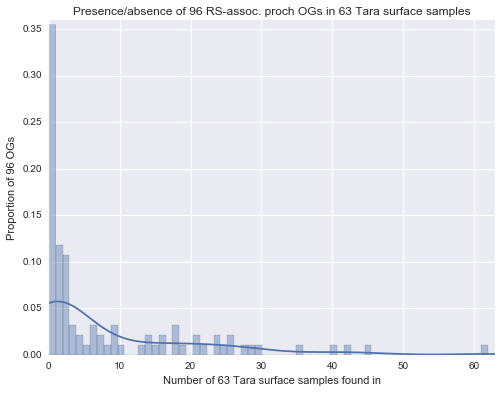

In [117]:
# RS-assoc OGs
plt.figure(figsize=(8,6))
sns.distplot(count_rs, bins=num_samples+1)
plt.axis([-0, num_samples, 0, .25])
plt.xlabel('Number of %s Tara surface samples found in' % num_samples)
plt.ylabel('Proportion of %s OGs' % num_ogs_rsonly)
plt.title('Presence/absence of %s RS-assoc. %s OGs in %s Tara surface samples' % (num_ogs_rsonly, species, num_samples))
plt.axis(myaxis)
plt.savefig('hist_%s_RSassoc_og_presence_absence_in_63_tara_srf.pdf' % species)

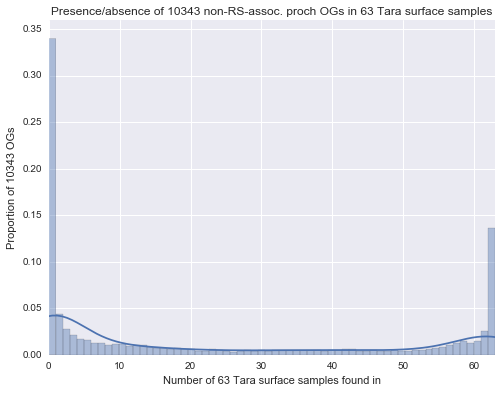

In [118]:
# other (non-RS-assoc) OGs
plt.figure(figsize=(8,6))
sns.distplot(count_other, bins=num_samples+1)
plt.axis([0, num_samples, 0, .4])
plt.xlabel('Number of %s Tara surface samples found in' % num_samples)
plt.ylabel('Proportion of %s OGs' % num_ogs_other)
plt.title('Presence/absence of %s non-RS-assoc. %s OGs in %s Tara surface samples' % (num_ogs_other, species, num_samples))
plt.axis(myaxis)
plt.savefig('hist_%s_nonRSassoc_og_presence_absence_in_63_tara_srf.pdf' % species)